In [1]:
import pandas as pd
import numpy as np
from itertools import *

### Step 0: Business quesitons

##### Goal: fill NaNs in dataset, so that it can be passed on to an ML model
- I. fill NaNs
- II. keep as many observations as possible
- III. keep as many features as possible

### Outline:
1. load in data
2. summary, count nans
3. feature engineering
    - (a) datetime cols
    - (b) categorical cols
    - -> correlation matrix of each angle
4. investigate nans
5. options
    - selected mix of drop cols, ML regression model with xgboost, and drop rows
6. solution part 1: drop cols
7. solution part 2a: ML regression model with xgboost
8. solution part 2b: drop rows for nan cols below accuracy threshold
9. Summary
    - 91% of observations retained with accuracy of filling missing values of 80% or higher
    - final dataset is 131,000 observations
10. export dataset

### Step 1: load in data

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment',None)
np.set_printoptions(threshold=np.inf)

def open_data(repo, file):
    with open("".join([repo, file]), "r", errors="ignore") as r:
        file = pd.read_csv(r, engine="python", parse_dates=["Date"])
        print(file.info())
    return file

repo = r"C:/Users/benno/OneDrive/Python/Dash/Deployment_ready/rainfall_aus/assets/data/"
file = "weatherAUS.csv"

rain = open_data(repo, file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

### Step 2: summarize data
- most cols have missing values
- category of "highly sparse" columns @ 50-60% nonnulls
- category of "90s" columns @ 90-99% nonnulls

In [3]:
import warnings
warnings.filterwarnings("ignore")

def summary_dataframe_small(df):

	return pd.DataFrame({'features': df.columns,'dtypes': [df.dtypes[i] for i in range(len(df.columns))],
	'nulls':[df[df.columns[i]].isnull().sum() for i in range(len(df.columns))],'nonnuls / 1.0': (df.shape[0] - 
	df.isnull().sum().values) / df.shape[0],'uniques': [df[j].nunique() for j in df.columns]})

summary_dataframe_small(rain)

,features,dtypes,nulls,nonnuls / 1.0,uniques
0,Date,datetime64[ns],0,1.000000,3436
1,Location,object,0,1.000000,49
2,MinTemp,float64,1485,0.989791,389
3,MaxTemp,float64,1261,0.991331,505
4,Rainfall,float64,3261,0.977581,681
5,Evaporation,float64,62790,0.568335,358
6,Sunshine,float64,69835,0.519902,145
7,WindGustDir,object,10326,0.929011,16
8,WindGustSpeed,float64,10263,0.929445,67
9,WindDir9am,object,10566,0.927361,16


In [4]:
def summary_dataframe_large(df):
    
    summary = pd.DataFrame({
        "feature": df.columns,
        "dtype" : [str(df[col].dtype) for col in df.columns],
        "nulls": [f"{df[col].isnull().sum()}" for col in df.columns],
        "nonnulls%": [f"{round(((1 - df[col].isnull().sum() / len(df)) * 100), 2)}%" for col in df.columns],
        "STATS": ["|" for col in df.columns],
        "min": [df[col].min().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "50%": [df[col].median().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " "for col in df.columns],
        "max": [df[col].max().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "stdev": [df[col].std().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "mean": [df[col].mean().round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else " " for col in df.columns],
        "skew": ["" if not any(t in str(df[col].dtype) for t in ("float", "int")) else "left" if df[col].median() > df[col].mean() else "right" if df[col].median() < df[col].mean() else "equal" for col in df.columns],
        "cat_mode": [" " if any(t in str(df[col].dtype) for t in ("float", "int")) else df[col].mode()[0] for col in df.columns],        
        "cat_mode": [" " if any(t in str(df[col].dtype) for t in ("float", "int")) else df[col].mode()[0] for col in df.columns],
        "COUNTS": ["|" for col in df.columns],
        "nuniques": [df[col].nunique() for col in df.columns],
        "vcs-": [df[col].value_counts().reset_index()["count"].min() for col in df.columns],
        "vcs+": [df[col].value_counts().reset_index()["count"].max() for col in df.columns],
        "RANDOM": ["|" for col in df.columns],
        "row[random]" :[df[col].iloc[np.random.randint(len(df))].round(2) if any(t in str(df[col].dtype) for t in ("float", "int")) else df[col].iloc[np.random.randint(len(df))] for col in df.columns],
    })

    print(df.shape)

    return summary
    
summary = summary_dataframe_large(rain)
summary

(145460, 23)


,feature,dtype,nulls,nonnulls%,STATS,min,50%,max,stdev,mean,skew,cat_mode,COUNTS,nuniques,vcs-,vcs+,RANDOM,row[random]
0,Date,datetime64[ns],0,100.0%,|,,,,,,,2013-03-01 00:00:00,|,3436,1,49,|,2011-03-25 00:00:00
1,Location,object,0,100.0%,|,,,,,,,Canberra,|,49,1578,3436,|,Cobar
2,MinTemp,float64,1485,98.98%,|,-8.5,12.0,33.9,6.4,12.19,right,,|,389,1,899,|,21.8
3,MaxTemp,float64,1261,99.13%,|,-4.8,22.6,48.1,7.12,23.22,right,,|,505,1,885,|,18.7
4,Rainfall,float64,3261,97.76%,|,0.0,0.0,371.0,8.48,2.36,right,,|,681,1,91080,|,0.2
5,Evaporation,float64,62790,56.83%,|,0.0,4.8,145.0,4.19,5.47,right,,|,358,1,3339,|,NaN
6,Sunshine,float64,69835,51.99%,|,0.0,8.4,14.5,3.79,7.61,left,,|,145,1,2359,|,NaN
7,WindGustDir,object,10326,92.9%,|,,,,,,,W,|,16,6548,9915,|,W
8,WindGustSpeed,float64,10263,92.94%,|,6.0,39.0,135.0,13.61,40.04,right,,|,67,1,9215,|,50.0
9,WindDir9am,object,10566,92.74%,|,,,,,,,N,|,16,7024,11758,|,ESE


In [6]:
rain.shape

(145460, 23)

### Step 3a: Feature Engineering, datetime
- datetime cols

In [105]:
rain_ml = rain.copy()

In [106]:
from datetime import datetime as dt

for df in [rain_ml]:
    df['Datetime'] = df['Date'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S"))
    df['Weekday'] = [t.day_name() for t in df.Datetime]
    df['Month'] = [t.month_name() for t in df.Datetime]
    df['Day'] = [t.day for t in df.Datetime]
    df['Hour'] = [t.hour for t in df.Datetime]
    df['Minute'] = [t.minute for t in df.Datetime]
    df['Date'] = [t.date() for t in df.Datetime]

In [107]:
# drop "datetime" dtype cols as some ml models cannot handle this datatype
rain_ml = rain_ml.drop(["Datetime", "Date"], axis=1)

##### Correlation, angle (A)
- after datetime col creation
- before onehot encoding

In [108]:
import plotly.io as pio
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def heatmap_allfeatures_pearson(df, height=800, colors="Oryel"):

    df = df.select_dtypes(["number"])

    corr = df.corr().round(2)
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr = corr.mask(mask)

    g = px.imshow(corr, text_auto=True, color_continuous_scale=colors, zmin=-1, zmax=1)

    g.update_layout(
    { "template": "plotly_white",
     "title": "heatmap, pearson correlation",
    "xaxis":{"showgrid": False,
             "zeroline": False},
    "yaxis": {"showgrid": False,
             "zeroline": False},
     "height": height,
   }).update_traces(xgap=2,ygap=2)

    return g, corr

fig, corr = heatmap_allfeatures_pearson(rain_ml, height=700, colors="RdYlBu_r")
fig

### Step 3b: Feature Engineering of categoricals
 - onehot encoding

In [110]:
def pull_categoricals(df):
    return [j for j in df.columns if "object" in str(df[j].dtype)]

categoricals = pull_categoricals(rain_ml)

In [111]:
categoricals

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow',
 'Weekday',
 'Month']

In [112]:
def pull_continuous(df, categoricals):
    return [j for j in df.columns if j not in categoricals]

continuous = pull_continuous(rain_ml, categoricals)

In [113]:
from sklearn.preprocessing import OneHotEncoder

def onehot_final(df, categoricals):	

	return pd.DataFrame(OneHotEncoder().fit_transform(df[categoricals].astype(str)).toarray(),
    columns = [i for j in [[str(j) + '_' + str(i) for i in np.unique(df[j].astype(str).values)] for j in categoricals] for i in j]
    ).reset_index().rename(columns={"index": "id"}).merge(df.drop(categoricals, axis=1).reset_index().rename(columns={"index": "id"})).drop(["id"], axis=1)

rain_ml = onehot_final(rain_ml, categoricals)

##### Correlation, angle (B)
- onehot encoded columns
- zoom in to see data vis


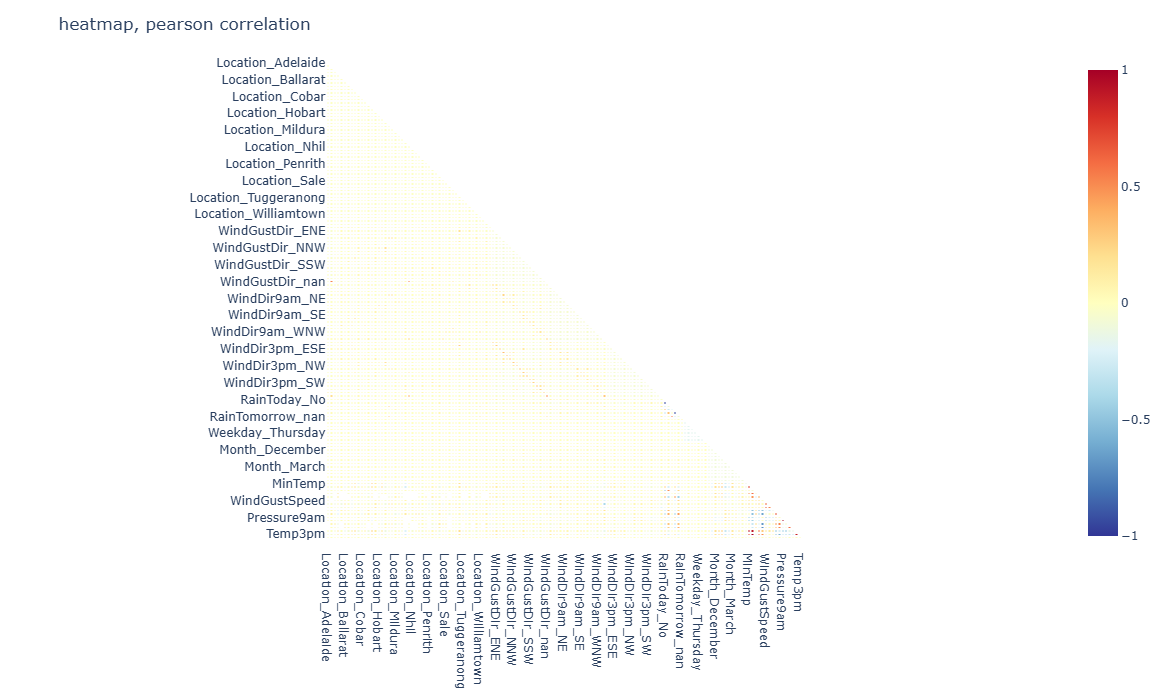

In [114]:
fig, corr = heatmap_allfeatures_pearson(rain_ml, height=700, colors="RdYlBu_r")
fig

### Step 4: investigate NaNs

In [115]:
summary_dataframe_small(rain_ml)

,features,dtypes,nulls,nonnuls / 1.0,uniques
0,Location_Adelaide,float64,0,1.000000,2
1,Location_Albany,float64,0,1.000000,2
2,Location_Albury,float64,0,1.000000,2
3,Location_AliceSprings,float64,0,1.000000,2
4,Location_BadgerysCreek,float64,0,1.000000,2
5,Location_Ballarat,float64,0,1.000000,2
6,Location_Bendigo,float64,0,1.000000,2
7,Location_Brisbane,float64,0,1.000000,2
8,Location_Cairns,float64,0,1.000000,2
9,Location_Canberra,float64,0,1.000000,2


In [116]:
rain_ml.columns[-19:]

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Day', 'Hour', 'Minute'],
      dtype='object')

In [117]:
nancols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm',]

In [122]:
nan1_mk = ( rain_ml["MinTemp"].isnull() )
s0_mk = ( rain_ml["Sunshine"] == 0 )
c0_mk = (rain_ml["Cloud9am"] == 0 )

# rain_ml[nan_mk][:50]
# rain_ml[s0_mk].iloc[:50, -19:]
# rain_ml[c0_mk].iloc[:50, -19:]

### Step 4: Findings
data appears to be **MCAR**, with the missing data not forming a pattern

### Step 5: Options to deal with missing values

##### Problem 1: 50-60% missing value columns
- option 0: gather new data
- option 1: drop rows (keep about 35% of the data)
- option 2: drop columns (keep all observation-wise data, don't consider cols with nulls)

##### Problem 2: 90-99% missing value columns
- option 0: gather new data
- option 1: drop rows (keep about 80% of the data)
- option 2: drop columns (this would be the majority of the data deleted)
- option 3: interpolation with ML model (guess the values using the data at hand; 83-98% accuracy)

##### Solutions
- problem 1:
    - option 2
- problem 2:
    - option 3, then option 1 

### Step 6: Solution 1), Drop Cols
drop class of feature with 50-60% nonnulls

In [38]:
dropcols = ["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"]
rain_ml = rain_ml.drop(dropcols, axis=1)

### Step 7: Solution 2.i) ML Regression Model
- -> 1x: test performance among all models
- -> 2x: select model, remove other models, predict, and interpolate

In [124]:
#1x:

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

model_lst = [
    LinearRegression(n_jobs=-1),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_jobs=-1),
    GradientBoostingRegressor(),
    xgb.XGBRegressor(n_jobs=-1),
]

In [33]:
# 2x:

model_lst = [
    xgb.XGBRegressor(n_jobs=-1),
]

In [36]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def model_selection_kfold_regression(models, df, dep_var): 

    df = df.dropna().reset_index(drop=True)

    data = df.drop([dep_var],axis=1).squeeze()
    target = df[[dep_var]].squeeze()

    idx = np.random.choice(range(0,len(df)), size=round(len(df)*0.80), replace=False)

    x_train = data.iloc[idx].reset_index(drop=True)
    y_train = target.iloc[idx].reset_index(drop=True)

    x_test = data.iloc[data.index.difference(idx)].reset_index(drop=True)
    y_test = target.iloc[data.index.difference(idx)].reset_index(drop=True)    
    
    scores_dct = {}    
    
    for model in models:
        
        clf = model

        clf.fit(x_train, y_train)
                
        preds = clf.predict(x_test)

        cv_score = np.mean(cross_val_score(clf, data, target, cv=KFold(n_splits=5, shuffle=True, random_state=42)))
        
        scores_dct[str(model)] = {}
        scores_dct[str(model)]["model"] = model        
        scores_dct[str(model)]["preds"] = preds        
        scores_dct[str(model)]["scores"] = {
            'mean_squared_error':metrics.mean_squared_error(preds, y_test),
             'train':clf.score(x_train, y_train),
             'test':clf.score(x_test, y_test),
             'cv':cv_score
        }
        
    
    return scores_dct

In [42]:
def scores_dct_to_df(dct):

    df = pd.DataFrame(
        index=["XGBoost" if "base_score" in str(j) else str(j) for j in dct.keys()],
        columns=list(np.array(list(dct.values()))[0]["scores"].keys()),
        data=[list(j["scores"].values()) for j in list(dct.values())]
    )

    return df

In [39]:
def interpolate_via_model(df, column, model):
    
    interpolate = pd.DataFrame({
        "true": df[column],
        "preds": model.predict(df.drop([column], axis=1)),
    })
    
    nan_mk = ( interpolate["true"].isnull() )
    interpolate["true"][nan_mk] = interpolate["preds"][nan_mk]
    
    return interpolate["true"]

##### Step 7a) feature "MinTemp"
- 1x: sampling of models

In [125]:
model_dct_mintemp = model_selection_kfold_regression(model_lst, rain_ml, "MinTemp")
scores_df = scores_dct_to_df(model_dct_mintemp)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,2.190219,0.965316,0.947272,0.947149
RandomForestRegressor(n_jobs=-1),2.547111,0.991072,0.938680,0.936481
GradientBoostingRegressor(),2.826498,0.932775,0.931954,0.930290
LinearRegression(n_jobs=-1),2.846081,0.932403,0.931483,0.931926
DecisionTreeRegressor(),5.685217,1.000000,0.863133,0.861712


In [50]:
model_mintemp = model_dct_mintemp[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["MinTemp"] = interpolate_via_model(rain_ml, "MinTemp", model_mintemp)

##### Step 7b) feature "MaxTemp"
- 2x: after viewing above format for all features, select model that perfoms the best

In [53]:
scores_dct_maxtemp = model_selection_kfold_regression(model_lst, rain_ml, "MaxTemp")
scores_df = scores_dct_to_df(scores_dct_maxtemp)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,0.706987,0.989355,0.985508,0.985372


In [55]:
model_maxtemp = scores_dct_maxtemp[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["MaxTemp"] = interpolate_via_model(rain_ml, "MaxTemp", model_maxtemp)

##### Step 7c) feature "Rainfall"
- model performed below threshold of 80%; do not use model to interpoate

In [58]:
scores_dct_rainfall = model_selection_kfold_regression(model_lst, rain_ml, "Rainfall")
scores_df = scores_dct_to_df(scores_dct_rainfall)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,40.273336,0.766166,0.413907,0.417833


In [66]:
# model_rainfall = scores_dct_rainfall["XGBRegress"]["model"]
# rain_ml["Rainfall"] = interpolate_via_model(rain_ml, "Rainfall", model_rainfall)

##### Step 7d) feature "WindSpeed9am"
- model performed below threshold of 80%; do not use model to interpoate

In [60]:
# 1:
scores_dct_ws9am = model_selection_kfold_regression(model_lst, rain_ml, "WindSpeed9am")
scores_df = scores_dct_to_df(scores_dct_ws9am)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,23.956862,0.754109,0.690856,0.691779


In [71]:
# model_ws9am = scores_dct_ws9am["XGBRegress"]["model"]
# rain_ml["WindSpeed9am"] = interpolate_via_model(rain_ml, "WindSpeed9am", model_ws9am)

##### Step 7e) feature "WindSpeed3pm"
- model performed below threshold of 80%; do not use model to interpoate

In [62]:
scores_dct_ws3pm = model_selection_kfold_regression(model_lst, rain_ml, "WindSpeed3pm")
scores_df = scores_dct_to_df(scores_dct_ws3pm)
scores_df.sort_values(by=["mean_squared_error"], ascending=True)

,mean_squared_error,train,test,cv
XGBoost,23.016821,0.754854,0.70048,0.692222


In [75]:
# model_ws3pm = scores_dct_ws3pm["XGBRegress"]["model"]
# rain_ml["WindSpeed3pm"] = interpolate_via_model(rain_ml, "WindSpeed3pm", model_ws3pm)

##### Step 7f) feature "Humidity9am"

In [64]:
scores_dct_h9am = model_selection_kfold_regression(model_lst, rain_ml, "Humidity9am")
scores_df = scores_dct_to_df(scores_dct_h9am)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,59.649094,0.872095,0.835663,0.838415


In [66]:
model_h9am = scores_dct_h9am[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["Humidity9am"] = interpolate_via_model(rain_ml, "Humidity9am", model_h9am)

##### Step 7g) feature "Humidity3pm"

In [68]:
scores_dct_h3pm = model_selection_kfold_regression(model_lst, rain_ml, "Humidity3pm")
scores_df = scores_dct_to_df(scores_dct_h3pm)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,53.276094,0.906784,0.874827,0.879066


In [70]:
model_h3pm = scores_dct_h3pm[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["Humidity3pm"] = interpolate_via_model(rain_ml, "Humidity3pm", model_h3pm)

##### Step 7h) feature "Pressure9am"

In [72]:
scores_dct_p9am = model_selection_kfold_regression(model_lst, rain_ml, "Pressure9am")
scores_df = scores_dct_to_df(scores_dct_p9am)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,1.497506,0.977979,0.970408,0.97038


In [74]:
model_p9am = scores_dct_p9am[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["Pressure9am"] = interpolate_via_model(rain_ml, "Pressure9am", model_p9am)

##### Step 7i) feature "Pressure3pm"

In [76]:
# 1
scores_dct_p3pm = model_selection_kfold_regression(model_lst, rain_ml, "Pressure3pm")
scores_df = scores_dct_to_df(scores_dct_p3pm)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,1.495878,0.977298,0.969537,0.969271


In [78]:
model_p3pm = scores_dct_p3pm[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["Pressure3pm"] = interpolate_via_model(rain_ml, "Pressure3pm", model_p3pm)

##### Step 7j) feature "Temp9am"

In [80]:
scores_dct_t9am = model_selection_kfold_regression(model_lst, rain_ml, "Temp9am")
scores_df = scores_dct_to_df(scores_dct_t9am)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,1.173762,0.977961,0.972456,0.972573


In [82]:
model_t9am = scores_dct_t9am[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["Temp9am"] = interpolate_via_model(rain_ml, "Temp9am", model_t9am)

##### Step 7j) feature "Temp3pm"

In [84]:
scores_dct_t3pm = model_selection_kfold_regression(model_lst, rain_ml, "Temp3pm")
scores_df = scores_dct_to_df(scores_dct_t3pm)
scores_df.sort_values(by=["mean_squared_error"],ascending=True)

,mean_squared_error,train,test,cv
XGBoost,0.620288,0.990708,0.987416,0.987183


In [87]:
model_t3pm = scores_dct_t3pm[list(model_dct_mintemp.keys())[0]]["model"]
rain_ml["Temp3pm"] = interpolate_via_model(rain_ml, "Temp3pm", model_t3pm)

### Step 7: Summary
- 3 features did not perform well enough to use interpolation methods
- 8 features did perform well enough, with scores test && cv >= 80%

### Step 8: Solution 2.ii) Drop Rows
where 3 above features are nan

In [90]:
rain_ml1 = rain_ml.copy()

In [91]:
rain_ml1 = rain_ml1.dropna()

In [127]:
rain_ml1.shape

(132181, 140)

### Step 9: Summarize
- Final removed columns numbers 4
- Final row-wise retention is ~132,000 / ~145,000, or **90.9% retention of observations**
- Final shape is 132,181 x 140 with 0 null values


In [95]:
rain_ml1.shape[0] / len(rain_ml)

0.9087102983638113

### Step 10: Export data
locally

In [128]:
repo = r"C:/Users/benno/OneDrive/Python/Dash/Deployment_ready/rainfall_aus/assets/data/"
file = "weatherAUS_cleaned.csv"

rain_ml1.to_csv("".join([repo, file]), index=False)

In [130]:
summary_dataframe_large(rain_ml1)

(132181, 140)


,feature,dtype,nulls,nonnulls%,STATS,min,50%,max,stdev,mean,skew,cat_mode,COUNTS,nuniques,vcs-,vcs+,RANDOM,row[random]
0,Location_Adelaide,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,3064,129117,|,1.0
1,Location_Albany,float64,0,100.0%,|,0.00,0.0,0.00,0.00,0.00,equal,,|,1,132181,132181,|,0.0
2,Location_Albury,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,2984,129197,|,0.0
3,Location_AliceSprings,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,2978,129203,|,0.0
4,Location_BadgerysCreek,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,2864,129317,|,0.0
5,Location_Ballarat,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,2992,129189,|,0.0
6,Location_Bendigo,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,2993,129188,|,0.0
7,Location_Brisbane,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,3122,129059,|,0.0
8,Location_Cairns,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,2969,129212,|,0.0
9,Location_Canberra,float64,0,100.0%,|,0.00,0.0,1.00,0.15,0.02,right,,|,2,3073,129108,|,0.0
